# Analysis, detection & mitigation of felonious wallet accounts over the Ethereum Blockchain network using Machine Learning techniques

| BITS ID No. | Name of Student    | Email                          | Mobile     |
| ------------| ------------------ | ------------------------------ | ---------- |
| 2019HC04178 | Anjali Sunder Naik | sundernaik.anjali@in.bosch.com | 8147757114 |

# Category : Smart Contract

# 1. Problem Statement

As of 2021, a survey from Coin Market Cap indicates that there are nearly over 6,000 digital coins in the market, a severe increase from just a handful since 2013. However, a large portion of these cryptocurrencies might not be that significant. The total market cap of all the crypto assets, including stable coins and tokens has shown a significant rise from year 2020 and has hit 2.4 trillion. Cryptocurrencies has vast potential of revolutionizing and transforming compliance-free peer-to-peer transactions. However, an end user must overcome certain challenges related to privacy, security, and control. As the transactions are recorded in a publicly distributed ledger known as blockchain, hackers have a large attack surface to gain access to critical and sensitive data. In the rapidly growing crypto currency space, the technological advent of cryptocurrencies and their respective benefits has been veiled with several illicit financing activities operating over the network such as ransomware, terrorist financing, hacking, data manipulation during transaction process, phishing, fraud, money laundering, bribery etc. Chainalysis, a firm that tracks every crypto currency transaction and serves as an advisor to an array of government authorities has published a report that shows that the amount of cryptocurrency spent on dark net markets rose 60% to reach a new high of $1.15billion from July 2020 to June 2021

# 2. Data Collection
1. What kind of problem are we trying to solve?
    - Fraud Detection, Categorical Analysis
2. What data sources already exist?
    - Ethereum Foundation Blacklist, Etherscan, Harvard Verse 
3. What privacy concerns are there?
    - NA
4. Is the data public?
    - Yes
5. Where should we store the files?
    - Local Store
6. What is the type of data collected?
    - Structured

# 3. Data Preparation

We collect the raw list of valid and invalid (blacklisted) ethereum accounts from ether scan, which are a combination of both EOA & Smart Contracts

In [1]:
# imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display
from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
import xgboost as xgb

import pickle

In [2]:
# constants

invalid_data_path = '../data/invalid/invalid.csv'
valid_data_path = '../data/valid/valid.csv'

sc_features_path_valid = '../data/valid/features_valid/part-r-00001'
sc_feat_valid = '../data/valid/features_valid/part-c-00001.csv'

sc_features_path_invalid = '../data/invalid/features_invalid/part-r-00001'
sc_feat_invalid = '../data/invalid/features_invalid/part-c-00001.csv'

sc_feat_valid_file_path = './exec-results/sc/sc_feat_valid.csv'
sc_feat_invalid_file_path = './exec-results/sc/sc_feat_invalid.csv'

## 3.1 Data Visualization

### 3.1.1 Felonious Accounts

In [3]:
df = pd.read_csv(invalid_data_path)

print("Total number of felonious accounts in the dataset: ",df.shape[0])

df.head()

Total number of felonious accounts in the dataset:  8476


,Address,Name Tag,Balance,Txn Count,label
0,0x9f26ae5cd245bfeeb5926d61497550f79d9c6c1c,Akropolis Hacker 1,0 Ether,29.0,phish-hack
1,0xbceaa0040764009fdcff407e82ad1f06465fd2c4,Bancor Hacker,0 Ether,3.0,phish-hack
2,0x03b70dc31abf9cf6c1cf80bfeeb322e8d3dbb4ca,Browser Extension Hack,0 Ether,64.0,phish-hack
3,0x4639cd8cd52ec1cf2e496a606ce28d8afb1c792f,CBDAO: BREE Token,0 Ether,6897.0,phish-hack
4,0xeda5066780de29d00dfb54581a707ef6f52d8113,ChainSwap Hacker,0.11961143 Ether,771.0,phish-hack


<AxesSubplot:title={'center':'Felonious Ethereum Accounts data'}>

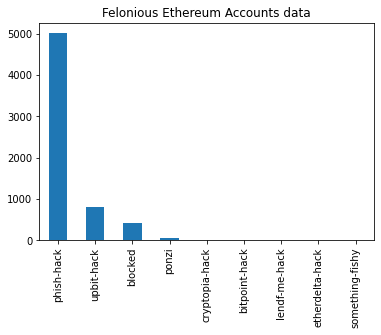

In [4]:
plt.title("Felonious Ethereum Accounts data")
df['label'].value_counts().plot(kind='bar')

### 3.1.2 Non-Felonious Accounts

In [5]:
df = pd.read_csv(valid_data_path)

print("Total number of non-felonious accounts in the dataset: ",df.shape[0])

df.head()

Total number of non-felonious accounts in the dataset:  8843


,Address
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8
1,0x0002b44ddb1476db43c868bd494422ee4c136fed
2,0x001f99982965a3792077893ecadc7be0c61d613c
3,0x0045eb75acf6e1cb1d9ec41e352a879e2cd50b35
4,0x00472c1e4275230354dbe5007a5976053f12610a


### 3.1.3 Feature Extraction

In [6]:
with open(sc_features_path_valid) as fin, open(sc_feat_valid, 'w') as fout:
    for line in fin:
        fout.write(line.replace('\t', ','))
        
df = pd.read_csv(sc_feat_valid)

sc_features_header = [
    'address',
    "f1_contract_creation_time",
    "f2_transaction_fee_spent_contract_creation",
    "f3_percentage_gas_used_contract_creation",
    "f4_gas_price_contract_creation",
    "f5_first_contract_invoke_time",
    "f6_last_contract_invoke_time",
    "f7_active_duration",
    "f8_total_invocations",
    "f9_total_unique_invocations",
    "f10_avg_gas_used_contract_invocations",
    "f11_total_gas_price_contract_invocations",
    "f12_avg_gas_price_contract_invocations",
    "f13_total_tx_fee_contract_invocations",
    "f14_avg_tx_fee_contract_invocations",
    "f15_total_ether_contract_invocations",
    "f16_average_ether_contract_invocations",
    "f17_total_gas_used_contract_invocations",
    "f18_avg_gas_used_contract_invocations",
    "class"]
  
# converting data frame to csv
df.to_csv(sc_feat_valid_file_path, header=sc_features_header, index=False)
  
# display modified csv file
df = pd.read_csv(sc_feat_valid_file_path)
df.head()
print("Total number of Valid SC in the dataset: ",df.shape[0])

Total number of Valid SC in the dataset:  5133


In [7]:
with open(sc_features_path_invalid) as fin, open(sc_feat_invalid, 'w') as fout:
    for line in fin:
        fout.write(line.replace('\t', ','))
        
df1 = pd.read_csv(sc_feat_invalid)
  
# converting data frame to csv
df1.to_csv(sc_feat_invalid_file_path, header=sc_features_header, index=False)
  
# display modified csv file
df1 = pd.read_csv(sc_feat_invalid_file_path)

print("Total number of invalid SC in the dataset: ",df1.shape[0])
df1.head()

Total number of invalid SC in the dataset:  450


,address,f1_contract_creation_time,f2_transaction_fee_spent_contract_creation,f3_percentage_gas_used_contract_creation,f4_gas_price_contract_creation,f5_first_contract_invoke_time,f6_last_contract_invoke_time,f7_active_duration,f8_total_invocations,f9_total_unique_invocations,f10_avg_gas_used_contract_invocations,f11_total_gas_price_contract_invocations,f12_avg_gas_price_contract_invocations,f13_total_tx_fee_contract_invocations,f14_avg_tx_fee_contract_invocations,f15_total_ether_contract_invocations,f16_average_ether_contract_invocations,f17_total_gas_used_contract_invocations,f18_avg_gas_used_contract_invocations,class
0,0x003eb9c77b5b896fcc27adead606d23def34510e,1636173593,3266079,100.000000,72547219921,1636174226,1640401957,4227731,88,61,46096.0,10543273660407,1.198099e+11,5322900,60487.0,0,0,4056463,46096.0,1
1,0x00bbd61f1f46bb2882e59af47b69dd7b501d5317,1599895831,1436718,100.000000,77000000000,1600061504,1606645255,6583751,3,3,41178.0,196100000000,6.536667e+10,182216,60738.0,0,0,123534,41178.0,1
2,0x0128e4fccf5ef86b030b28f0a8a029a3c5397a94,1598245046,3905623,66.666675,63000000000,1598273279,1638516430,40243151,3159,1831,43217.0,538290501077085,1.703990e+11,198252748,62758.0,102643703810000000000,32492467176321620,136525623,43217.0,1
3,0x0135c9a7bff72aa26e1d105ff5000e454e4dde7a,1538679649,2002904,85.021748,41000000000,1538734262,1624903468,86169206,812,291,118913.0,17062958585000,2.101350e+10,215890531,265875.0,181517977659053835437,223544307461888959,96558052,118913.0,1
4,0x016913ead5672f01de2043874e5c1cac5df608de,1582089609,520521,100.000000,1000000000,1582090649,1634830631,52739982,648,304,40178.0,5142791470136,7.936407e+09,44709838,68996.0,0,0,26035362,40178.0,1


In [8]:
df_cd = pd.merge(df, df1, how='outer')
df_cd

,address,f1_contract_creation_time,f2_transaction_fee_spent_contract_creation,f3_percentage_gas_used_contract_creation,f4_gas_price_contract_creation,f5_first_contract_invoke_time,f6_last_contract_invoke_time,f7_active_duration,f8_total_invocations,f9_total_unique_invocations,f10_avg_gas_used_contract_invocations,f11_total_gas_price_contract_invocations,f12_avg_gas_price_contract_invocations,f13_total_tx_fee_contract_invocations,f14_avg_tx_fee_contract_invocations,f15_total_ether_contract_invocations,f16_average_ether_contract_invocations,f17_total_gas_used_contract_invocations,f18_avg_gas_used_contract_invocations,class
0,0x0000000a95cdc345c1f71e361ece941ab2149fbe,1635728204,3178800,100.0000,109005244127,1635731607,1640428473,4696866,20,21,53352.0,2508977189526,1.254489e+11,1603942,80197.0,1600000000000000000,80000000000000000,1067044,53352.0,0
1,0x0003ed19f80564745e84b4cc411a7b6be4f0cf31,1637812311,2242427,100.0000,117021837043,1637813619,1642351882,4538263,103,95,78849.0,13003658991308,1.262491e+11,9600623,93209.0,1888613390000000000,18336052330097087,8121502,78849.0,0
2,0x000bab4f6b5560d7942ac88cf0233b6028b5b465,1610716059,5508384,100.0000,85000000000,1610717234,1628590252,17873018,1793,915,209089.0,710445189065704,3.962327e+11,1375765866,767298.0,945306314519250361854,527220476586308065,374897418,209089.0,0
3,0x0012EdA08A762ff158E9B6401591DB80Ed875920,1638190945,1038037,100.0000,120000000000,1638327848,1638507016,179168,5,3,79185.0,694698051031,1.389396e+11,539476,107895.0,0,0,395928,79185.0,0
4,0x001b28141562bc2601694d27c3f5fda2c06c234c,1493694346,1000000,18.2055,40000000000,1494138003,1505628361,11490358,16,5,23839.0,390876604343,2.442979e+10,2499000,156187.0,12306659575886750800,769166223492921925,381426,23839.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,0xfb5c7aa982ebced4384eec4d5e732a28759ebdf8,1613217495,407167,100.0000,140000000000,1613829187,1614883856,1054669,3,2,36493.0,435935001728,1.453117e+11,232711,77570.0,0,0,109479,36493.0,1
5579,0xfb6e71e0800bccc0db8a9cf326fe3213ca1a0ea0,1529228634,500048,100.0000,1000000000,1529278381,1555110447,25832066,3,4,21966.0,12000000000,4.000000e+09,106968,35656.0,1001000000000000000,333666666666666666,65899,21966.0,1
5580,0xfe75aee72700ff0e0742c00d12acf2724827fa00,1607558032,1304042,100.0000,41000000000,1607558105,1607561101,2996,8,7,43465.0,323081431885,4.038518e+10,397484,49685.0,0,0,347723,43465.0,1
5581,0xff35866acb80ce4b169d1460cd48108955c1c445,1520437336,1338603,100.0000,2000000000,1520943011,1582740769,61797758,2,3,33343.0,26000000000,1.300000e+10,282000,141000.0,0,0,66686,33343.0,1


In [9]:
df = df_cd
df.drop(['address',], inplace=True, axis=1)
print(df.isnull().values.any())
nan_rows = df[df.isnull().T.any()]
nan_rows

False


,f1_contract_creation_time,f2_transaction_fee_spent_contract_creation,f3_percentage_gas_used_contract_creation,f4_gas_price_contract_creation,f5_first_contract_invoke_time,f6_last_contract_invoke_time,f7_active_duration,f8_total_invocations,f9_total_unique_invocations,f10_avg_gas_used_contract_invocations,f11_total_gas_price_contract_invocations,f12_avg_gas_price_contract_invocations,f13_total_tx_fee_contract_invocations,f14_avg_tx_fee_contract_invocations,f15_total_ether_contract_invocations,f16_average_ether_contract_invocations,f17_total_gas_used_contract_invocations,f18_avg_gas_used_contract_invocations,class


In [10]:
df.describe()

,f1_contract_creation_time,f2_transaction_fee_spent_contract_creation,f3_percentage_gas_used_contract_creation,f4_gas_price_contract_creation,f5_first_contract_invoke_time,f6_last_contract_invoke_time,f7_active_duration,f8_total_invocations,f9_total_unique_invocations,f10_avg_gas_used_contract_invocations,f11_total_gas_price_contract_invocations,f12_avg_gas_price_contract_invocations,f13_total_tx_fee_contract_invocations,f14_avg_tx_fee_contract_invocations,f17_total_gas_used_contract_invocations,f18_avg_gas_used_contract_invocations,class
count,5.583000e+03,5.583000e+03,5583.000000,5.583000e+03,5.583000e+03,5.583000e+03,5.583000e+03,5583.000000,5583.000000,5.583000e+03,5.583000e+03,5.583000e+03,5.583000e+03,5.583000e+03,5.583000e+03,5.583000e+03,5583.000000
mean,1.614582e+09,2.644937e+06,89.742961,1.014047e+11,1.614848e+09,1.620718e+09,5.869907e+06,640.276912,281.670965,1.525754e+05,6.231631e+13,1.094359e+11,1.229583e+08,2.856526e+05,6.919236e+07,1.525754e+05,0.080602
std,4.703349e+07,1.952463e+06,24.914508,5.112568e+10,4.685367e+07,4.321573e+07,1.263463e+07,1998.534777,941.538060,4.418192e+05,2.353333e+14,5.398691e+10,4.843047e+08,7.105705e+05,2.793443e+08,4.418192e+05,0.272247
min,1.441633e+09,7.193300e+04,2.351950,2.675370e+08,1.441633e+09,1.470174e+09,0.000000e+00,1.000000,2.000000,2.100000e+04,1.000000e+09,1.000000e+09,2.100000e+04,2.100000e+04,2.100000e+04,2.100000e+04,0.000000
25%,1.634906e+09,1.172539e+06,100.000000,7.279642e+10,1.635052e+09,1.635737e+09,3.485500e+04,7.000000,4.000000,4.620900e+04,6.528795e+11,8.308274e+10,1.077291e+06,8.205550e+04,5.026850e+05,4.620900e+04,0.000000
50%,1.636382e+09,2.149310e+06,100.000000,1.029000e+11,1.636464e+09,1.637891e+09,2.421452e+06,27.000000,11.000000,6.650400e+04,2.774789e+12,1.127497e+11,5.605552e+06,1.446660e+05,3.113432e+06,6.650400e+04,0.000000
75%,1.637583e+09,3.326120e+06,100.000000,1.317814e+11,1.637694e+09,1.641833e+09,6.400044e+06,140.500000,72.000000,1.522875e+05,1.501474e+13,1.407283e+11,2.449318e+07,2.663485e+05,1.346608e+07,1.522875e+05,0.000000
max,1.638785e+09,2.808272e+07,100.000000,5.010000e+11,1.643586e+09,1.643635e+09,1.763339e+08,9999.000000,8678.000000,1.653884e+07,4.678485e+15,7.803328e+11,9.399060e+09,1.658887e+07,7.694851e+09,1.653884e+07,1.000000


## Information Gain

Information gain calculates the reduction in entropy from the transformation of a dataset. It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable.

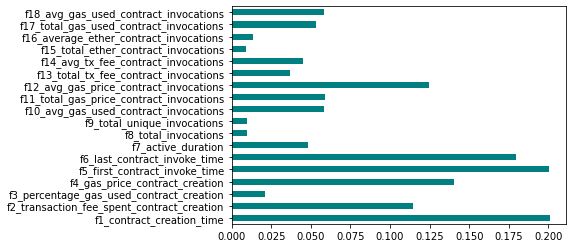

f1_contract_creation_time 0.2012582898157813
f5_first_contract_invoke_time 0.20043490336190617
f6_last_contract_invoke_time 0.179211553031543
f4_gas_price_contract_creation 0.14047210049203573
f12_avg_gas_price_contract_invocations 0.12440789872541136
f2_transaction_fee_spent_contract_creation 0.11480564305480434
f11_total_gas_price_contract_invocations 0.05919944770421259
f18_avg_gas_used_contract_invocations 0.05859698304821159
f10_avg_gas_used_contract_invocations 0.058288528292604
f17_total_gas_used_contract_invocations 0.05342361341653068

The top 10 features for Smart Contract DF are :
Index(['f1_contract_creation_time', 'f5_first_contract_invoke_time',
       'f6_last_contract_invoke_time', 'f4_gas_price_contract_creation',
       'f12_avg_gas_price_contract_invocations',
       'f2_transaction_fee_spent_contract_creation',
       'f11_total_gas_price_contract_invocations',
       'f18_avg_gas_used_contract_invocations',
       'f10_avg_gas_used_contract_invocations',
       'f1

In [11]:
# Let's convert the DataFrame object to a NumPy array to achieve faster computation. 
# Also, let's segregate the data into separate variables so that the features and the labels are separated.

array = df.values

X = array[:,0:18]
Y = array[:,18]

Y = Y.astype('int')

%matplotlib inline

importances = mutual_info_classif(X,Y)
feat_importances = pd.Series(importances, df.columns[0:len(df.columns)-1])
feat_importances.plot(kind = 'barh', color = 'teal')

plt.show()

# Show the top 10 high scored features
threshold = 10  # the number of most relevant features
high_score_features = []

for score, f_name in sorted(zip(feat_importances, df.columns), reverse=True)[:threshold]:
        print(f_name, score)
        high_score_features.append(f_name)
        
eoa_df_top_features = df[high_score_features]

print("\nThe top "+"% s" % threshold + " features for Smart Contract DF are :")
print(eoa_df_top_features.columns)

In [12]:
col  =  eoa_df_top_features.columns
cl = col.append(pd.Index(['class']))
cl

Index(['f1_contract_creation_time', 'f5_first_contract_invoke_time',
       'f6_last_contract_invoke_time', 'f4_gas_price_contract_creation',
       'f12_avg_gas_price_contract_invocations',
       'f2_transaction_fee_spent_contract_creation',
       'f11_total_gas_price_contract_invocations',
       'f18_avg_gas_used_contract_invocations',
       'f10_avg_gas_used_contract_invocations',
       'f17_total_gas_used_contract_invocations', 'class'],
      dtype='object')

In [13]:
evaluation_df = df[cl]
evaluation_df

,f1_contract_creation_time,f5_first_contract_invoke_time,f6_last_contract_invoke_time,f4_gas_price_contract_creation,f12_avg_gas_price_contract_invocations,f2_transaction_fee_spent_contract_creation,f11_total_gas_price_contract_invocations,f18_avg_gas_used_contract_invocations,f10_avg_gas_used_contract_invocations,f17_total_gas_used_contract_invocations,class
0,1635728204,1635731607,1640428473,109005244127,1.254489e+11,3178800,2508977189526,53352.0,53352.0,1067044,0
1,1637812311,1637813619,1642351882,117021837043,1.262491e+11,2242427,13003658991308,78849.0,78849.0,8121502,0
2,1610716059,1610717234,1628590252,85000000000,3.962327e+11,5508384,710445189065704,209089.0,209089.0,374897418,0
3,1638190945,1638327848,1638507016,120000000000,1.389396e+11,1038037,694698051031,79185.0,79185.0,395928,0
4,1493694346,1494138003,1505628361,40000000000,2.442979e+10,1000000,390876604343,23839.0,23839.0,381426,0
...,...,...,...,...,...,...,...,...,...,...,...
5578,1613217495,1613829187,1614883856,140000000000,1.453117e+11,407167,435935001728,36493.0,36493.0,109479,1
5579,1529228634,1529278381,1555110447,1000000000,4.000000e+09,500048,12000000000,21966.0,21966.0,65899,1
5580,1607558032,1607558105,1607561101,41000000000,4.038518e+10,1304042,323081431885,43465.0,43465.0,347723,1
5581,1520437336,1520943011,1582740769,2000000000,1.300000e+10,1338603,26000000000,33343.0,33343.0,66686,1


# 4. Training

In [14]:
dfs = []
results = []
names = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
target_names = ['felonious', 'non-felonious']

## Data Splitting
We split the dataset into 80%-20% for the training and testing of our model.

In [15]:
array = evaluation_df.values

X = array[:,0:10]
y = array[:,10]

## 4.1 k-NN Classifier

In [16]:
le = LabelEncoder()
X[:,0] = le.fit_transform(X[:,0])

In [17]:
# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [18]:
# Feature Scaling

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
# Training the K-NN model on the Training set

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
cv_results = model_selection.cross_validate(classifier, X_train, y_train, cv=kfold, scoring=scoring)


classifier.fit(X_train, y_train)


pickle.dump(classifier, open('exec-results/sc/models/knn.pkl','wb'))

In [20]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [21]:
# Making the Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)
print(cm)
print(ac)

[[1023    7]
 [  27   60]]
0.9695613249776186


In [22]:
# for analysis
name = 'KNN'
results.append(cv_results)
names.append(name)
this_df = pd.DataFrame(cv_results)
this_df['model'] = name
dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)

## 4.2 Decision Tree Classifier

In [23]:
# Splitting the data - 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)


print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)

Training split input-  (4466, 10)
Testing split input-  (1117, 10)


In [24]:
# Defining the decision tree algorithm
dtree=DecisionTreeClassifier()

kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
cv_results = model_selection.cross_validate(dtree, X_train, y_train, cv=kfold, scoring=scoring)

dtree.fit(X_train,y_train)
pickle.dump(classifier, open('exec-results/sc/models/dt.pkl','wb'))

In [25]:
# Predicting the values of test data
y_pred = dtree.predict(X_test)
print("Classification report - \n", classification_report(y_test,y_pred))

Classification report - 
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1026
         1.0       0.87      0.78      0.82        91

    accuracy                           0.97      1117
   macro avg       0.92      0.88      0.90      1117
weighted avg       0.97      0.97      0.97      1117



Text(0.5, 1.0, 'Accuracy Score: 0.97224709042077')

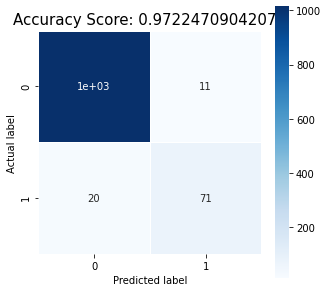

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(dtree.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

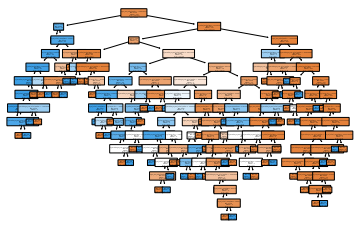

In [27]:
# Visualising the graph without the use of graphvizplt.figure(figsize = (20,20))
dec_tree = plot_tree(decision_tree=dtree, feature_names = df1.columns, 
                     class_names =["Invalid", "Valid"] , filled = True , precision = 4, rounded = True)

plt.savefig('./exec-results/sc/analysis/decision_tree.png',dpi=300)

In [28]:
# for analysis
name = 'DT'
results.append(cv_results)
names.append(name)
this_df = pd.DataFrame(cv_results)
this_df['model'] = name
dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)

## 4.3 Random Forest Classifier

In [29]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
cv_results = model_selection.cross_validate(clf, X_train, y_train, cv=kfold, scoring=scoring)

# Splitting the data - 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)
print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)


#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

pickle.dump(classifier, open('exec-results/sc/models/rf.pkl','wb'))

y_pred=clf.predict(X_test)

Training split input-  (4466, 10)
Testing split input-  (1117, 10)


In [30]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.9740376007162042


In [31]:
# for analysis
name = 'RF'
results.append(cv_results)
names.append(name)
this_df = pd.DataFrame(cv_results)
this_df['model'] = name
dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)

## 4.4 XGBoost Classifier

In [32]:
# Init classifier
xgb_cl = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder =False)

kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
cv_results = model_selection.cross_validate(xgb_cl, X_train, y_train, cv=kfold, scoring=scoring)

# Fit
xgb_cl.fit(X_train, y_train)

# Store
pickle.dump(classifier, open('exec-results/sc/models/xgb.pkl','wb'))

# Predict
preds = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, preds)

0.9749328558639212

In [33]:
# for analysis
name = 'XGB'
results.append(cv_results)
names.append(name)
this_df = pd.DataFrame(cv_results)
this_df['model'] = name
dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)

## 5. Analysis/Evaluation

In [34]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

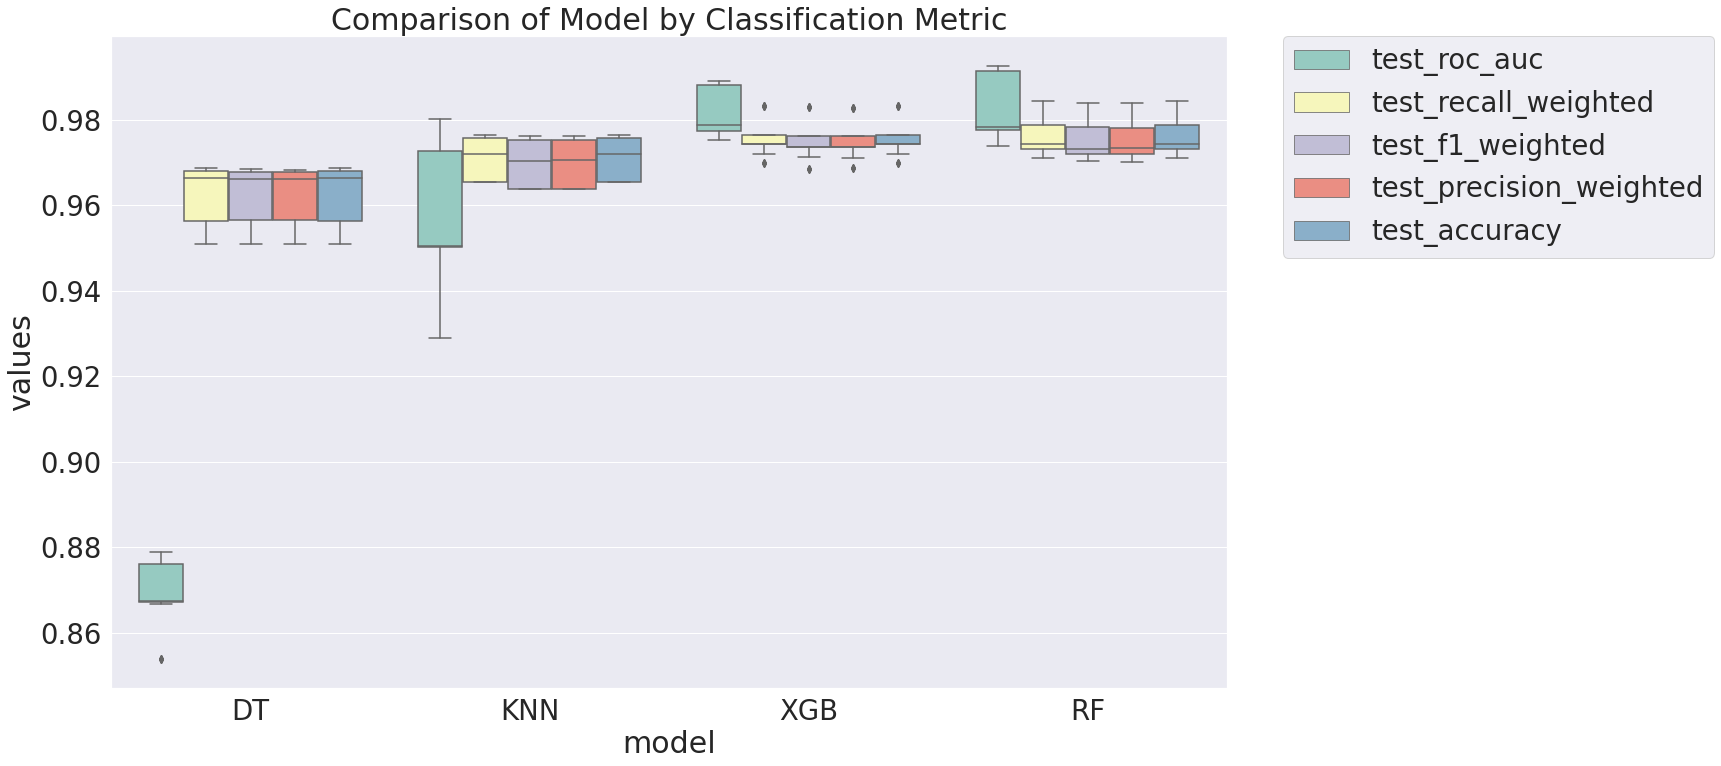

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./exec-results/sc/analysis/benchmark_models_performance.png',dpi=300)

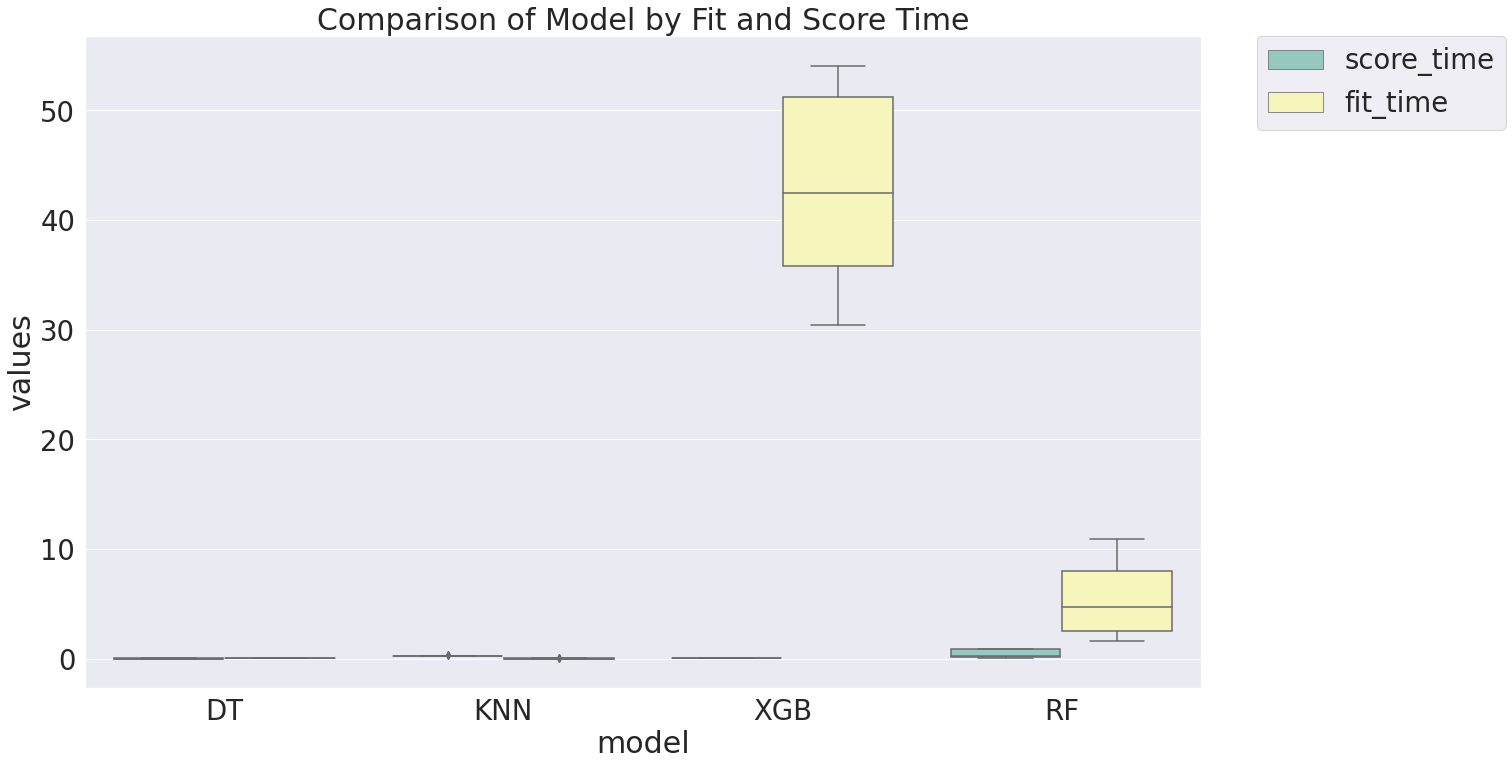

In [36]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./exec-results/sc/analysis/benchmark_models_time.png',dpi=300)

In [37]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_recall_weighted           test_precision_weighted            \
                       std      mean                     std      mean   
model                                                                    
DT                0.006870  0.961599                0.006600  0.961505   
KNN               0.004578  0.970552                0.005075  0.969376   
RF                0.004905  0.976788                0.005102  0.976054   
XGB               0.004325  0.975821                0.004554  0.975136   

      test_roc_auc           test_accuracy           test_f1_weighted  \
               std      mean           std      mean              std   
model                                                                   
DT        0.008175  0.868107      0.006870  0.961599         0.006727   
KNN       0.017451  0.954717      0.004578  0.970552         0.005035   
RF        0.007778  0.982353      0.004905  0.976788         0.005127   
XGB       0.005214  0.980775      0.004325  0.975821         0.004572   

                 
           mean  
model            
DT     0.961540  
KNN    0.969416  
RF     0.976044  
XGB    0.975254

In [38]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

fit_time            score_time          
            std       mean        std      mean
model                                          
DT     0.011406   0.065670   0.006887  0.020316
KNN    0.016856   0.031953   0.029273  0.250477
RF     3.468908   5.496498   0.362664  0.454302
XGB    8.661245  41.677520   0.018885  0.072613